## Analysis of The Driving Hamiltonian

#### Imports

In [28]:
from collections import Counter
from src.hamiltonian_utils import get_twobody_nuclearshell_model,FermiHubbardHamiltonian,SingleParticleState
import numpy as np
import torch
from typing import Dict
from src.qml_models import AdaptVQEFermiHubbard
from src.qml_utils.train import Fit
from src.qml_utils.utils import configuration
from scipy.sparse.linalg import eigsh,expm_multiply
from tqdm import trange
import matplotlib.pyplot as plt
import scipy

def plot_spectrum(eigenvalues):
    """
    Plot the vertical spectrum of a Hamiltonian, showing the eigenvalues as horizontal lines 
    and indicating their degeneracy.

    Parameters:
    eigenvalues (array-like): Array of eigenvalues of the Hamiltonian.
    """
    # Count the degeneracy of each eigenvalue
    degeneracy = Counter(eigenvalues)

    # Prepare data for plotting
    unique_eigenvalues = list(degeneracy.keys())
    degeneracies = list(degeneracy.values())

    # Plot the spectrum
    plt.figure(figsize=(6, 10))
    for i, (eig, deg) in enumerate(zip(unique_eigenvalues, degeneracies)):
        plt.hlines(eig, i - 0.2 * deg, i + 0.2 * deg, colors='b', linewidth=5)
        plt.text(i, eig, f'{deg}', horizontalalignment='center', verticalalignment='bottom', fontsize=24, color='r')

    # Make the plot fancy
    plt.title('Spectrum of the Hamiltonian', fontsize=16)
    plt.ylabel('Eigenvalue', fontsize=14)
    plt.xlabel('Index (degeneracy indicated by text)', fontsize=14)
    plt.xticks(range(len(unique_eigenvalues)), ['']*len(unique_eigenvalues))  # Remove x-axis ticks
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()

    # Show the plot
    plt.show()

file_name='data/cki'
SPS=SingleParticleState(file_name=file_name)
energies=SPS.energies

#### Hyperparameters

In [29]:
nparticles_a=3
nparticles_b=3

size_a=SPS.energies.shape[0]//2
size_b=SPS.energies.shape[0]//2




J and M operator and the single particle Basis

In [30]:
matrix_j,_=get_twobody_nuclearshell_model(file_name='data/j2.int')

energies=SPS.energies

diag_j=np.zeros(energies.shape[0])
diag_m=np.zeros(energies.shape[0])
label=[]
for i in range(energies.shape[0]):
    n,l,j,m,_,tz=SPS.state_encoding[i]
    label.append((j,m,tz))
    diag_j[i]=j*(j+1)
    diag_m[i]=m

Joperator = FermiHubbardHamiltonian(
    size_a=size_a,
    size_b=size_b,
    nparticles_a=nparticles_a,
    nparticles_b=nparticles_b,
)

Joperator.get_twobody_interaction(twobody_dict=matrix_j)
Joperator.get_external_potential(diag_j)
Joperator.get_hamiltonian()

Jdiagoperator=FermiHubbardHamiltonian(
    size_a=size_a,
    size_b=size_b,
    nparticles_a=nparticles_a,
    nparticles_b=nparticles_b,
)

Jdiagoperator.get_external_potential(diag_j)
Jdiagoperator.get_hamiltonian()


Moperator = FermiHubbardHamiltonian(
    size_a=size_a,
    size_b=size_b,
    nparticles_a=nparticles_a,
    nparticles_b=nparticles_b,
)

Moperator.get_external_potential(diag_m)
Moperator.get_hamiltonian()


Computing the matrix, pls wait... (u_u) 



100%|██████████| 12/12 [00:01<00:00,  7.19it/s]
592it [00:00, 894.27it/s]


#### Target Hamiltonian

In [31]:
twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)

habcd=np.zeros((energies.shape[0],energies.shape[0],energies.shape[0],energies.shape[0]))
iso_dict={-0.5:'n',0.5:'p'}
values=np.asarray(list(twobody_matrix.values()))
print(np.average(np.abs(values)))
for key in twobody_matrix.keys():
    i,j,k,l=key
    habcd[i,j,k,l]=twobody_matrix[key]
    (n,_,ja,ma,_,tza)=SPS.state_encoding[i]
    (n,_,jb,mb,_,tzb)=SPS.state_encoding[j]
    (n,_,jc,mc,_,tzc)=SPS.state_encoding[k]
    (n,_,jd,md,_,tzd)=SPS.state_encoding[l]

    print(ja,ma,iso_dict[tza]+'+'+iso_dict[tzb],jb,mb,'-->',jc,mc,iso_dict[tzc]+'+'+iso_dict[tzd],jd,md)
    print('cross section=',twobody_matrix[key],'\n')
    


average_unit_energy=np.average(np.abs(np.asarray(list(twobody_matrix.values()))))

Computing the matrix, pls wait... (u_u) 



100%|██████████| 12/12 [00:02<00:00,  5.18it/s]


1.4069726715197104
1.5 -1.5 p+p 1.5 -0.5 --> 1.5 -1.5 p+p 1.5 -0.5
cross section= -0.6490000000000002 

1.5 -1.5 p+p 1.5 -0.5 --> 1.5 -0.5 p+p 1.5 -1.5
cross section= 0.6490000000000002 

1.5 -0.5 p+p 1.5 -1.5 --> 1.5 -1.5 p+p 1.5 -0.5
cross section= 0.6490000000000002 

1.5 -0.5 p+p 1.5 -1.5 --> 1.5 -0.5 p+p 1.5 -1.5
cross section= -0.6490000000000002 

1.5 -1.5 p+p 1.5 -0.5 --> 1.5 -1.5 p+p 0.5 -0.5
cross section= 2.2055000000000007 

1.5 -1.5 p+p 1.5 -0.5 --> 0.5 -0.5 p+p 1.5 -1.5
cross section= -2.2055000000000007 

1.5 -0.5 p+p 1.5 -1.5 --> 1.5 -1.5 p+p 0.5 -0.5
cross section= -2.2055000000000007 

1.5 -0.5 p+p 1.5 -1.5 --> 0.5 -0.5 p+p 1.5 -1.5
cross section= 2.2055000000000007 

1.5 -1.5 p+p 1.5 0.5 --> 1.5 -1.5 p+p 1.5 0.5
cross section= -0.6490000000000002 

1.5 -1.5 p+p 1.5 0.5 --> 1.5 0.5 p+p 1.5 -1.5
cross section= 0.6490000000000002 

1.5 0.5 p+p 1.5 -1.5 --> 1.5 -1.5 p+p 1.5 0.5
cross section= 0.6490000000000002 

1.5 0.5 p+p 1.5 -1.5 --> 1.5 0.5 p+p 1.5 -1.5
cross sectio

In [32]:
TargetHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b)
print('size=',size_a+size_b,size_b)
TargetHamiltonian.get_external_potential(external_potential=energies[:size_a+size_b])
TargetHamiltonian.get_twobody_interaction(twobody_dict=twobody_matrix)
TargetHamiltonian.get_hamiltonian()

nlevels=3

egs,psis=TargetHamiltonian.get_spectrum(n_states=nlevels)

egs=egs[0]
print(egs)
psi0=psis[:,0]


print('total_m=',SPS.compute_m_exp_value(psi=psi0,basis=TargetHamiltonian.basis))


# check the commutator
#print('commutator=',TargetHamiltonian.hamiltonian @ InitialHamiltonian.hamiltonian - InitialHamiltonian.hamiltonian @ TargetHamiltonian.hamiltonian)







j2=psi0.transpose().dot(Joperator.hamiltonian.dot(psi0))
jvalue=0.5 * ( np.sqrt(4.0 * j2 + 1) - 1 )

print('total_J=',jvalue)
print('m value=',Moperator.hamiltonian @ TargetHamiltonian.hamiltonian- TargetHamiltonian.hamiltonian @ Moperator.hamiltonian)

size= 12 6


92it [00:00, 913.69it/s]

1424it [00:01, 946.05it/s] 


-41.221454571302836
total_m= 0.0
total_J= 3.885780586188048e-15
m value= 


particle distribution

In [9]:
n_expectation_nsmodel=np.zeros((nlevels,size_a+size_b))

for j in range(nlevels):
    for i in range(size_a+size_b):
        
        op=TargetHamiltonian.adag_a_matrix(i=i,j=i)
        n_expectation_nsmodel[j,i]=( (psis[:,j].conjugate().transpose() @ op @ psis[:,j]))



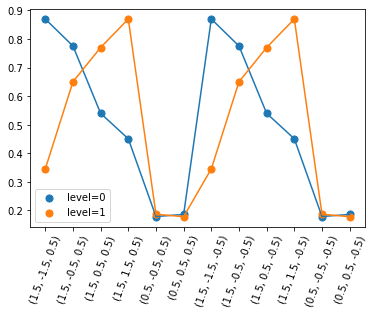

18.000000000000007


In [10]:
for i in range(2):
    plt.plot(n_expectation_nsmodel[i])
    plt.scatter(np.arange(energies.shape[0]),n_expectation_nsmodel[i],s=50,label=f'level={i}')
    plt.xticks(np.arange(energies.shape[0]),label,rotation=70)
plt.legend()
plt.show()

print(np.sum(n_expectation_nsmodel))

##### Correlation Matrix

In [11]:
correlation_matrix=np.zeros((size_a+size_b,size_a+size_b))
for i in range(size_a):
    for j in range(size_a):
        op=TargetHamiltonian.adag_a_matrix(i=i,j=j)
        correlation_matrix[j,i]=( (psis[:,0].conjugate().transpose() @ op @ psis[:,0]))
        
for i in range(size_a,size_a+size_b):
    for j in range(size_a,size_a+size_b):
        op=TargetHamiltonian.adag_a_matrix(i=i,j=j)
        correlation_matrix[j,i]=( (psis[:,0].conjugate().transpose() @ op @ psis[:,0]))

Plot

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, '(1.5, -1.5, 0.5)'),
  Text(1, 0, '(1.5, -0.5, 0.5)'),
  Text(2, 0, '(1.5, 0.5, 0.5)'),
  Text(3, 0, '(1.5, 1.5, 0.5)'),
  Text(4, 0, '(0.5, -0.5, 0.5)'),
  Text(5, 0, '(0.5, 0.5, 0.5)'),
  Text(6, 0, '(1.5, -1.5, -0.5)'),
  Text(7, 0, '(1.5, -0.5, -0.5)'),
  Text(8, 0, '(1.5, 0.5, -0.5)'),
  Text(9, 0, '(1.5, 1.5, -0.5)'),
  Text(10, 0, '(0.5, -0.5, -0.5)'),
  Text(11, 0, '(0.5, 0.5, -0.5)')])

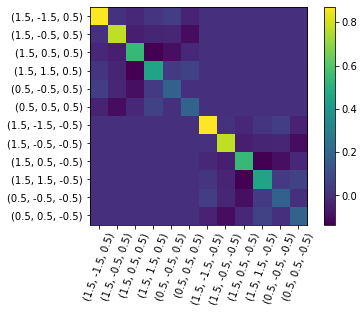

In [12]:
plt.imshow(correlation_matrix)
plt.colorbar()
plt.xticks(np.arange(energies.shape[0]),label,rotation=70)
plt.yticks(np.arange(energies.shape[0]),label)
plt.xticks()

(1, 0, 1.5, -1.5, 0.5, 0.5) (1, 0, 1.5, -1.5, 0.5, 0.5) 0.7034090412635298 

(1, 0, 1.5, -1.5, 0.5, 0.5) (1, 0, 1.5, -0.5, 0.5, 0.5) -1.236799709396243e-15 

(1, 0, 1.5, -1.5, 0.5, 0.5) (1, 0, 1.5, 0.5, 0.5, 0.5) 3.756743566607692e-16 

(1, 0, 1.5, -1.5, 0.5, 0.5) (1, 0, 1.5, 1.5, 0.5, 0.5) -9.017837002152794e-19 

(1, 0, 1.5, -1.5, 0.5, 0.5) (1, 0, 0.5, -0.5, 0.5, 0.5) -1.0361596288424862e-15 

(1, 0, 1.5, -1.5, 0.5, 0.5) (1, 0, 0.5, 0.5, 0.5, 0.5) 6.211097547805589e-16 

(1, 0, 1.5, -1.5, 0.5, 0.5) (1, 0, 1.5, -1.5, 0.5, -0.5) 0.0 

(1, 0, 1.5, -1.5, 0.5, 0.5) (1, 0, 1.5, -0.5, 0.5, -0.5) 0.0 

(1, 0, 1.5, -1.5, 0.5, 0.5) (1, 0, 1.5, 0.5, 0.5, -0.5) 0.0 

(1, 0, 1.5, -1.5, 0.5, 0.5) (1, 0, 1.5, 1.5, 0.5, -0.5) 0.0 

(1, 0, 1.5, -1.5, 0.5, 0.5) (1, 0, 0.5, -0.5, 0.5, -0.5) 0.0 

(1, 0, 1.5, -1.5, 0.5, 0.5) (1, 0, 0.5, 0.5, 0.5, -0.5) 0.0 

(1, 0, 1.5, -0.5, 0.5, 0.5) (1, 0, 1.5, -1.5, 0.5, 0.5) -1.236799709396243e-15 

(1, 0, 1.5, -0.5, 0.5, 0.5) (1, 0, 1.5, -0.5, 0.5, 0.5) 0.70340904

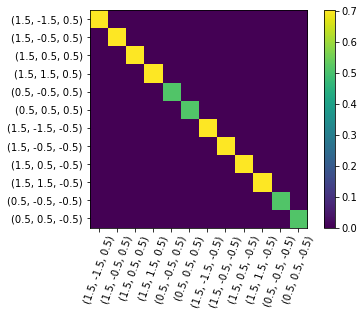

In [ ]:
adj_plus=np.einsum('abcd,bc->ad',habcd,correlation_matrix)/(energies.shape[0])
adj_minus=np.einsum('abcd,ad->bc',habcd,correlation_matrix)/(energies.shape[0])
adj=0.5*(adj_plus+adj_minus)

for i in range(energies.shape[0]):
    for j in range(energies.shape[0]):
        print(SPS.state_encoding[i],SPS.state_encoding[j],adj[i,j],'\n')
plt.imshow(adj)
plt.xticks(np.arange(energies.shape[0]),label,rotation=70)
plt.yticks(np.arange(energies.shape[0]),label)
plt.colorbar()
plt.show()

#### Case a: Driver Hamiltonian A

In [5]:
omega=3

t=omega
w=omega
h=omega


In [22]:
InitialHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b)

kinetic_term:Dict={}
adj_matrix=np.zeros((size_a+size_b,size_a+size_b))

#cki
j_values=[1/2,3/2]

print(t,w)


mj_list=[]
for j in j_values:
    m_values=-2*j+2*np.arange(0,int(2*j)+1)
    
    m_values=m_values[m_values>0.]
    for m in m_values:
        mj_list.append((m/2,j,1))

for tzi in [-1/2,1/2]:
    
    for f,tupi in enumerate(mj_list):
        mi,ji,ni=tupi
        #mj,jj,nj=mj_list[(f+1)% len(mj_list)]
        for tupj in mj_list:
            mj,jj,nj=tupj
            if mi!=mj:
                print(mi,mj)
                continue
            if ji==jj:
                continue
            print('otherwise=',mi,mj)
            #if ni==nj:
            i=SPS.get_index((ni,0,ji,mi,1/2,tzi))
            k=SPS.get_index((ni,0,ji,-1*mi,1/2,tzi))
            j=SPS.get_index((nj,0,jj,mj,1/2,tzi))
            l=SPS.get_index((nj,0,jj,-1*mj,1/2,tzi))
            kinetic_term[(i,j)]=(t/2+w/2) #np.abs(mi-mj)#+np.abs(ji-jj)
            adj_matrix[i,j]=(t/2+w/2)#np.abs(mi-mj)#+np.abs(ji-jj)
            kinetic_term[(j,i)]=(t/2+w/2) #np.abs(mi-mj)#+np.abs(ji-jj)
            adj_matrix[j,i]=(t/2+w/2)#np.abs(mi-mj)#+np.abs(ji-jj)
            
            kinetic_term[(i,l)]=(t/2-w/2) #np.abs(mi-mj)#+np.abs(ji-jj)
            adj_matrix[i,l]=(t/2-w/2)#np.abs(mi-mj)#+np.abs(ji-jj)
            kinetic_term[(l,i)]=(t/2-w/2) #np.abs(mi-mj)#+np.abs(ji-jj)
            adj_matrix[l,i]=(t/2-w/2)#np.abs(mi-mj)#+np.abs(ji-jj)
            
            kinetic_term[(k,j)]=(t/2-w/2) #np.abs(mi-mj)#+np.abs(ji-jj)
            adj_matrix[k,j]=(t/2-w/2)#np.abs(mi-mj)#+np.abs(ji-jj)
            kinetic_term[(j,k)]=(t/2-w/2) #np.abs(mi-mj)#+np.abs(ji-jj)
            adj_matrix[j,k]=(t/2-w/2)#np.abs(mi-mj)#+np.abs(ji-jj)
            
            kinetic_term[(k,l)]=(t/2+w/2) #np.abs(mi-mj)#+np.abs(ji-jj)
            adj_matrix[k,l]=(t/2+w/2)#np.abs(mi-mj)#+np.abs(ji-jj)
            
            kinetic_term[(l,k)]=(t/2+w/2) #np.abs(mi-mj)#+np.abs(ji-jj)
            adj_matrix[l,k]=(t/2+w/2)#np.abs(mi-mj)#+np.abs(ji-jj)
        


                
external_field=np.zeros(size_a+size_b)
rand=np.random.uniform(0,1,3)
rand_dict={1/2:rand[0],-1/2:rand[1]}
for i in range(size_a+size_b):
    (ni,li,ji,mi,ti,tzi)=SPS.state_encoding[i]
    j=SPS.get_index((ni,li,ji,-mi,ti,tzi))
    external_field[i]=h*(ji)


    
    #external_field[i] = SPS.energies[i]


InitialHamiltonian.get_kinetic_operator(adj_matrix=kinetic_term)
InitialHamiltonian.get_external_potential(external_field)
InitialHamiltonian.get_hamiltonian()

nlevels=8

es,psis=InitialHamiltonian.get_spectrum(n_states=nlevels)
einitial=es[0]
psi_initial=psis[:,0]
print('total_m=',SPS.compute_m_exp_value(psi=psi_initial,basis=InitialHamiltonian.basis))
print('total J^2=',psi_initial.transpose().conjugate() @ Joperator.hamiltonian @ psi_initial)
plt.figure(figsize=(10,10))

plt.title(r'$A_{ij}$ where $H_0=\sum_{ij}A_{ij} c^{\dagger}_i c_j + h \sum_i j_i \hat{n}_i$',fontsize=20)
plt.imshow(adj_matrix)
plt.xticks(np.arange(diag_m.shape[0]),label,rotation=70)
plt.yticks(np.arange(diag_m.shape[0]),label)
plt.colorbar()
plt.savefig('images/fig4')
plt.tick_params(which='major',labelsize=20)
plt.axhline(y=energies.shape[0]//2-0.5,color='red',linestyle='--')
plt.axvline(x=energies.shape[0]//2-0.5,color='red',linestyle='--')

plt.axhline(y=energies.shape[0]-5.5,color='green',linestyle='--')
plt.axvline(x=energies.shape[0]-5.5,color='green',linestyle='--')


plt.axhline(y=energies.shape[0]-8.5,color='green',linestyle='--')
plt.axvline(x=energies.shape[0]-8.5,color='green',linestyle='--')

plt.show()

print(einitial)

#print(InitialHamiltonian.hamiltonian)
print('m value=',Moperator.hamiltonian @ InitialHamiltonian.hamiltonian- InitialHamiltonian.hamiltonian @ Moperator.hamiltonian)

NameError: name 't' is not defined

####  Driver Hamiltonian B

total_m= 5.551115123125783e-17
total J^2= 3.25


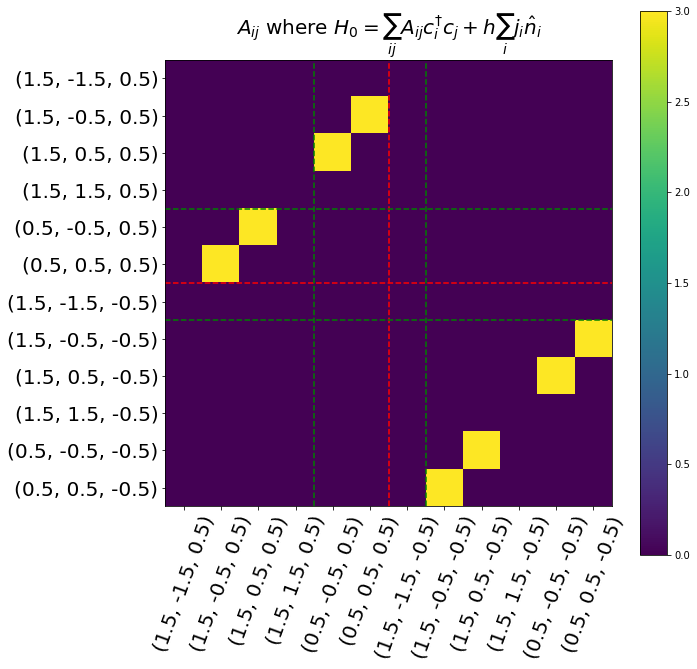

-6.0
m value=   (0, 4)	-3.0
  (1, 3)	3.0
  (3, 1)	-3.0
  (4, 0)	3.0
  (5, 7)	3.0
  (5, 11)	3.0
  (6, 13)	3.0
  (7, 5)	-3.0
  (7, 14)	3.0
  (9, 12)	-3.0
  (11, 5)	-3.0
  (11, 14)	3.0
  (12, 9)	3.0
  (13, 6)	-3.0
  (14, 7)	-3.0
  (14, 11)	-3.0


In [32]:
omega=3
omega_b=3
omega_c=omega/2

InitialHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b)

kinetic_term:Dict={}
adj_matrix=np.zeros((size_a+size_b,size_a+size_b))

#cki
j_values=[1/2,3/2]


mj_list=[]
for a in range(energies.shape[0]):
    for b in range(energies.shape[0]):
        (na,la,ja,ma,ta,tza)=SPS.state_encoding[a]
        (nb,lb,jb,mb,tb,tzb)=SPS.state_encoding[b]
        
        if ja==1.5 and ma==0.5 and jb==0.5 and mb==-0.5 and tza==tzb:
            kinetic_term[(a,b)]=omega
            kinetic_term[(b,a)]=omega
            adj_matrix[a,b]=omega
            adj_matrix[b,a]=omega
        
        if ja==0.5 and ma==0.5 and jb==1.5 and mb==-0.5 and tza==tzb:
            kinetic_term[(a,b)]=omega_b
            kinetic_term[(b,a)]=omega_b
            adj_matrix[a,b]=omega_b
            adj_matrix[b,a]=omega_b
        
        # if ja==1.5 and ma==0.5 and jb==1.5 and mb==-0.5 and tza==tzb:
        #     kinetic_term[(a,b)]=omega_c
        #     kinetic_term[(b,a)]=omega_c
        #     adj_matrix[a,b]=omega_c
        #     adj_matrix[b,a]=omega_c


                
external_field=np.zeros(size_a+size_b)
rand=np.random.uniform(0,1,3)
rand_dict={1/2:rand[0],-1/2:rand[1]}
for i in range(size_a+size_b):
    (ni,li,ji,mi,ti,tzi)=SPS.state_encoding[i]
    j=SPS.get_index((ni,li,ji,-mi,ti,tzi))
    if ji==1.5 and (mi)==0.5:
        external_field[i]=0
    if ji==0.5 and (mi)==-0.5:
        external_field[i]=0
        
    if ji==1.5 and (mi)==-0.5:
        external_field[i]=0
    if ji==0.5 and (mi)==0.5:
        external_field[i]=0
        
    if ji==1.5 and mi==1.5:
        external_field[i]=0
        
    if ji==1.5 and mi==-1.5:
        external_field[i]=0
        
    

    
    #external_field[i] = SPS.energies[i]


InitialHamiltonian.get_kinetic_operator(adj_matrix=kinetic_term)
InitialHamiltonian.get_external_potential(external_field)
InitialHamiltonian.get_hamiltonian()

nlevels=8

es,psis=InitialHamiltonian.get_spectrum(n_states=nlevels)
einitial=es[0]
psi_initial=psis[:,0]
print('total_m=',SPS.compute_m_exp_value(psi=psi_initial,basis=InitialHamiltonian.basis))
print('total J^2=',psi_initial.transpose().conjugate() @ Joperator.hamiltonian @ psi_initial)
plt.figure(figsize=(10,10))

plt.title(r'$A_{ij}$ where $H_0=\sum_{ij}A_{ij} c^{\dagger}_i c_j + h \sum_i j_i \hat{n}_i$',fontsize=20)
plt.imshow(adj_matrix+np.eye(energies.shape[0])*external_field[None,:])
plt.xticks(np.arange(diag_m.shape[0]),label,rotation=70)
plt.yticks(np.arange(diag_m.shape[0]),label)
plt.colorbar()
plt.savefig('images/fig4')
plt.tick_params(which='major',labelsize=20)
plt.axhline(y=energies.shape[0]//2-0.5,color='red',linestyle='--')
plt.axvline(x=energies.shape[0]//2-0.5,color='red',linestyle='--')

plt.axhline(y=energies.shape[0]-5.5,color='green',linestyle='--')
plt.axvline(x=energies.shape[0]-5.5,color='green',linestyle='--')


plt.axhline(y=energies.shape[0]-8.5,color='green',linestyle='--')
plt.axvline(x=energies.shape[0]-8.5,color='green',linestyle='--')

plt.show()

print(einitial)

#print(InitialHamiltonian.hamiltonian)
print('m value=',Moperator.hamiltonian @ InitialHamiltonian.hamiltonian- InitialHamiltonian.hamiltonian @ Moperator.hamiltonian)

####  Driver Hamiltonian A-bis

total_m= -2.828427124746195
total J^2= 14.750000000000018


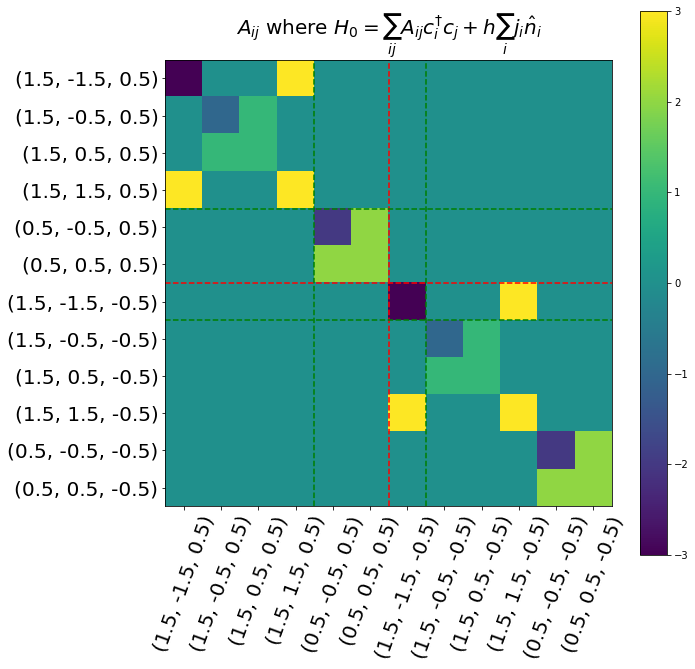

-14.14213562373097
m value=   (0, 1)	-1.0
  (0, 6)	9.0
  (0, 15)	-1.0
  (0, 90)	9.0
  (1, 0)	1.0
  (1, 9)	9.0
  (1, 16)	-1.0
  (1, 91)	9.0
  (2, 17)	-1.0
  (2, 92)	9.0
  (3, 4)	-2.0
  (3, 12)	-9.0
  (3, 18)	-1.0
  (3, 93)	9.0
  (4, 3)	2.0
  (4, 13)	-9.0
  (4, 19)	-1.0
  (4, 94)	9.0
  (5, 20)	-1.0
  (5, 95)	9.0
  (6, 0)	-9.0
  (6, 9)	-1.0
  (6, 21)	-1.0
  (6, 96)	9.0
  (7, 8)	-2.0
  :	:
  (209, 194)	2.0
  (210, 211)	-1.0
  (210, 216)	9.0
  (211, 210)	1.0
  (211, 219)	9.0
  (213, 214)	-2.0
  (213, 222)	-9.0
  (214, 213)	2.0
  (214, 223)	-9.0
  (216, 210)	-9.0
  (216, 219)	-1.0
  (217, 218)	-2.0
  (217, 220)	-1.0
  (218, 217)	2.0
  (218, 221)	-1.0
  (219, 211)	-9.0
  (219, 216)	1.0
  (220, 217)	1.0
  (220, 221)	-2.0
  (221, 218)	1.0
  (221, 220)	2.0
  (222, 213)	9.0
  (222, 223)	-2.0
  (223, 214)	9.0
  (223, 222)	2.0


In [164]:
omega=3
omega_b=2
omega_c=1

InitialHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b)

kinetic_term:Dict={}
adj_matrix=np.zeros((size_a+size_b,size_a+size_b))

#cki
j_values=[1/2,3/2]


mj_list=[]
for a in range(energies.shape[0]):
    for b in range(energies.shape[0]):
        (na,la,ja,ma,ta,tza)=SPS.state_encoding[a]
        (nb,lb,jb,mb,tb,tzb)=SPS.state_encoding[b]
        
        if ja==1.5 and ma==0.5 and jb==1.5 and mb==-0.5 and tza==tzb:
            kinetic_term[(a,b)]=omega
            kinetic_term[(b,a)]=omega
            adj_matrix[a,b]=omega
            adj_matrix[b,a]=omega
        
        if ja==0.5 and ma==0.5 and jb==0.5 and mb==-0.5 and tza==tzb:
            kinetic_term[(a,b)]=omega_b
            kinetic_term[(b,a)]=omega_b
            adj_matrix[a,b]=omega_b
            adj_matrix[b,a]=omega_b
        
        if ja==1.5 and ma==0.5 and jb==1.5 and mb==-0.5 and tza==tzb:
            kinetic_term[(a,b)]=omega_c
            kinetic_term[(b,a)]=omega_c
            adj_matrix[a,b]=omega_c
            adj_matrix[b,a]=omega_c
        
        if ja==1.5 and ma==1.5 and jb==1.5 and mb==-1.5 and tza==tzb:
            kinetic_term[(a,b)]=omega
            kinetic_term[(b,a)]=omega
            adj_matrix[a,b]=omega
            adj_matrix[b,a]=omega


                
external_field=np.zeros(size_a+size_b)
rand=np.random.uniform(0,1,3)
rand_dict={1/2:rand[0],-1/2:rand[1]}
for i in range(size_a+size_b):
    (ni,li,ji,mi,ti,tzi)=SPS.state_encoding[i]
    j=SPS.get_index((ni,li,ji,-mi,ti,tzi))
    if ji==1.5:
        if mi>0.:
            external_field[i]=omega
        if mi<0:
            external_field[i]=-omega
    
    if ji==1.5 and np.abs(mi)==0.5:
        if mi>0.:
            external_field[i]=omega_c
        if mi<0:
            external_field[i]=-omega_c
    
    if ji==0.5:
        if mi>0.:
            external_field[i]=omega_b 
        if mi<0:
            external_field[i]=-omega_b
        
    

    
    #external_field[i] = SPS.energies[i]


InitialHamiltonian.get_kinetic_operator(adj_matrix=kinetic_term)
InitialHamiltonian.get_external_potential(external_field)
InitialHamiltonian.get_hamiltonian()

nlevels=8

es,psis=InitialHamiltonian.get_spectrum(n_states=nlevels)
einitial=es[0]
psi_initial=psis[:,0]
print('total_m=',SPS.compute_m_exp_value(psi=psi_initial,basis=InitialHamiltonian.basis))
print('total J^2=',psi_initial.transpose().conjugate() @ Joperator.hamiltonian @ psi_initial)
plt.figure(figsize=(10,10))

plt.title(r'$A_{ij}$ where $H_0=\sum_{ij}A_{ij} c^{\dagger}_i c_j + h \sum_i j_i \hat{n}_i$',fontsize=20)
plt.imshow(adj_matrix+np.eye(energies.shape[0])*external_field[None,:])
plt.xticks(np.arange(diag_m.shape[0]),label,rotation=70)
plt.yticks(np.arange(diag_m.shape[0]),label)
plt.colorbar()
plt.savefig('images/fig4')
plt.tick_params(which='major',labelsize=20)
plt.axhline(y=energies.shape[0]//2-0.5,color='red',linestyle='--')
plt.axvline(x=energies.shape[0]//2-0.5,color='red',linestyle='--')

plt.axhline(y=energies.shape[0]-5.5,color='green',linestyle='--')
plt.axvline(x=energies.shape[0]-5.5,color='green',linestyle='--')


plt.axhline(y=energies.shape[0]-8.5,color='green',linestyle='--')
plt.axvline(x=energies.shape[0]-8.5,color='green',linestyle='--')

plt.show()

print(einitial)

#print(InitialHamiltonian.hamiltonian)
print('m value=',Moperator.hamiltonian @ InitialHamiltonian.hamiltonian- InitialHamiltonian.hamiltonian @ Moperator.hamiltonian)

#### Driver Hamiltonian D

In [21]:
twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)

habcd=np.zeros((energies.shape[0],energies.shape[0],energies.shape[0],energies.shape[0]))
iso_dict={-0.5:'n',0.5:'p'}
values=np.asarray(list(twobody_matrix.values()))
print(np.average(np.abs(values)))
for key in twobody_matrix.keys():
    i,j,k,l=key
    habcd[i,j,k,l]=twobody_matrix[key]
    (n,_,ja,ma,_,tza)=SPS.state_encoding[i]
    (n,_,jb,mb,_,tzb)=SPS.state_encoding[j]
    (n,_,jc,mc,_,tzc)=SPS.state_encoding[k]
    (n,_,jd,md,_,tzd)=SPS.state_encoding[l]

    print(ja,ma,iso_dict[tza]+'+'+iso_dict[tzb],jb,mb,'-->',jc,mc,iso_dict[tzc]+'+'+iso_dict[tzd],jd,md)
    print('cross section=',twobody_matrix[key],'\n')
    





Computing the matrix, pls wait... (u_u) 



100%|██████████| 12/12 [00:02<00:00,  5.53it/s]


1.4069726715197104
1.5 -1.5 p+p 1.5 -0.5 --> 1.5 -1.5 p+p 1.5 -0.5
cross section= -0.6490000000000002 

1.5 -1.5 p+p 1.5 -0.5 --> 1.5 -0.5 p+p 1.5 -1.5
cross section= 0.6490000000000002 

1.5 -0.5 p+p 1.5 -1.5 --> 1.5 -1.5 p+p 1.5 -0.5
cross section= 0.6490000000000002 

1.5 -0.5 p+p 1.5 -1.5 --> 1.5 -0.5 p+p 1.5 -1.5
cross section= -0.6490000000000002 

1.5 -1.5 p+p 1.5 -0.5 --> 1.5 -1.5 p+p 0.5 -0.5
cross section= 2.2055000000000007 

1.5 -1.5 p+p 1.5 -0.5 --> 0.5 -0.5 p+p 1.5 -1.5
cross section= -2.2055000000000007 

1.5 -0.5 p+p 1.5 -1.5 --> 1.5 -1.5 p+p 0.5 -0.5
cross section= -2.2055000000000007 

1.5 -0.5 p+p 1.5 -1.5 --> 0.5 -0.5 p+p 1.5 -1.5
cross section= 2.2055000000000007 

1.5 -1.5 p+p 1.5 0.5 --> 1.5 -1.5 p+p 1.5 0.5
cross section= -0.6490000000000002 

1.5 -1.5 p+p 1.5 0.5 --> 1.5 0.5 p+p 1.5 -1.5
cross section= 0.6490000000000002 

1.5 0.5 p+p 1.5 -1.5 --> 1.5 -1.5 p+p 1.5 0.5
cross section= 0.6490000000000002 

1.5 0.5 p+p 1.5 -1.5 --> 1.5 0.5 p+p 1.5 -1.5
cross sectio

KeyboardInterrupt: 

total_m= -0.6331223584718315
total J^2= 6.169222981287028


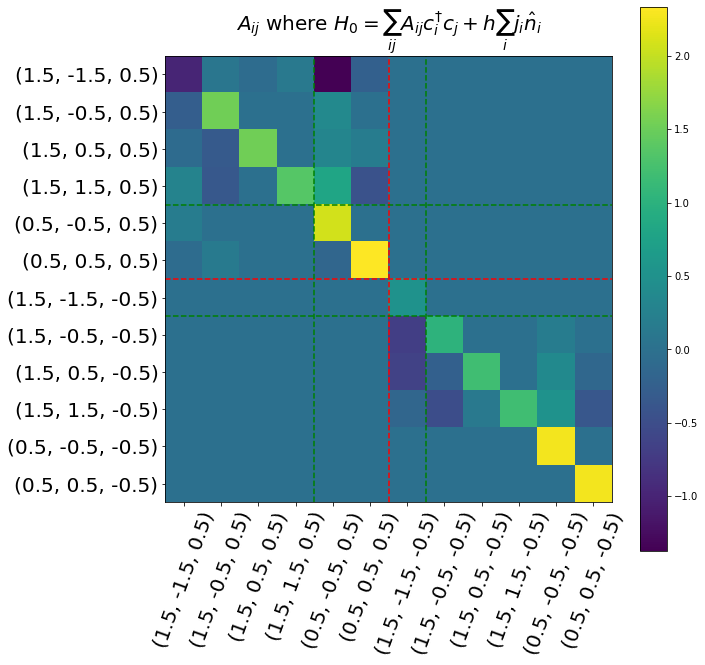

4.3543035689273575
m value=   (0, 15)	1.6222028951926244
  (0, 30)	-0.4435181142629788
  (0, 45)	-0.3183365046744301
  (0, 150)	-1.3704261849347406
  (0, 165)	-0.4687911874150493
  (1, 0)	-0.2335729645086185
  (1, 3)	0.38847486922285607
  (1, 16)	1.6222028951926242
  (1, 31)	-0.4435181142629789
  (1, 46)	-0.31833650467443003
  (1, 151)	-1.3704261849347406
  (1, 166)	-0.4687911874150493
  (2, 0)	-0.9844211830598493
  (2, 1)	0.13151392486325789
  (2, 3)	1.0334377999052073
  (2, 4)	-0.3605795889475453
  (2, 17)	1.6222028951926244
  (2, 32)	-0.4435181142629789
  (2, 47)	-0.31833650467443003
  (2, 152)	-1.3704261849347406
  (2, 167)	-0.4687911874150493
  (3, 18)	1.6222028951926244
  (3, 33)	-0.4435181142629788
  (3, 48)	-0.3183365046744301
  (3, 153)	-1.3704261849347406
  :	:
  (222, 162)	-0.1446118086752715
  (222, 192)	0.715283333333333
  (222, 207)	-0.3183365046744301
  (222, 213)	-0.4503775000000001
  (222, 217)	-0.9844211830598493
  (222, 220)	0.1315139248632579
  (222, 224)	0.36057958

In [22]:

InitialHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b)
adj_matrix=np.zeros((energies.shape[0],energies.shape[0]))
kinetic_term:Dict={}
hab=-(np.einsum('abcd->ad',habcd)/energies.shape[0]+np.einsum('abcd->bc',habcd)/energies.shape[0])

for a in range(energies.shape[0]//2):
    for b in range(energies.shape[0]//2):
        (_,_,ja,_,_,_)=SPS.state_encoding[a]
        (_,_,jb,_,_,_)=SPS.state_encoding[b]
        # if a==b:
        #     continue
        # if ja==jb:
        #     continue
        if hab[a,b]!=0. :
            kinetic_term[(a,b)]=hab[a,b]
            adj_matrix[a,b]=hab[a,b]

for a in range(energies.shape[0]//2,energies.shape[0]):
    for b in range(energies.shape[0]//2,energies.shape[0]):
        (_,_,ja,_,_,_)=SPS.state_encoding[a]
        (_,_,jb,_,_,_)=SPS.state_encoding[b]
        # if a==b:
        #     continue
        # if ja==jb:
        #     continue
        if hab[a,b]!=0.:
            kinetic_term[(a,b)]=hab[a,b]
            adj_matrix[a,b]=hab[a,b]

                
external_field=np.zeros(size_a+size_b)
rand=np.random.uniform(0,1,3)
rand_dict={1/2:rand[0],-1/2:rand[1]}
for i in range(size_a+size_b):
    external_field[i]=energies[i]
        
    

    
    #external_field[i] = SPS.energies[i]


InitialHamiltonian.get_kinetic_operator(adj_matrix=kinetic_term)
InitialHamiltonian.get_external_potential(external_field)
InitialHamiltonian.get_hamiltonian()

nlevels=8

es,psis=InitialHamiltonian.get_spectrum(n_states=nlevels)
einitial=es[0]
psi_initial=psis[:,0]
print('total_m=',SPS.compute_m_exp_value(psi=psi_initial,basis=InitialHamiltonian.basis))
print('total J^2=',psi_initial.transpose().conjugate() @ Joperator.hamiltonian @ psi_initial)
plt.figure(figsize=(10,10))

plt.title(r'$A_{ij}$ where $H_0=\sum_{ij}A_{ij} c^{\dagger}_i c_j + h \sum_i j_i \hat{n}_i$',fontsize=20)
plt.imshow(adj_matrix+np.eye(energies.shape[0])*external_field[None,:])
plt.xticks(np.arange(diag_m.shape[0]),label,rotation=70)
plt.yticks(np.arange(diag_m.shape[0]),label)
plt.colorbar()
plt.savefig('images/fig4')
plt.tick_params(which='major',labelsize=20)
plt.axhline(y=energies.shape[0]//2-0.5,color='red',linestyle='--')
plt.axvline(x=energies.shape[0]//2-0.5,color='red',linestyle='--')

plt.axhline(y=energies.shape[0]-5.5,color='green',linestyle='--')
plt.axvline(x=energies.shape[0]-5.5,color='green',linestyle='--')


plt.axhline(y=energies.shape[0]-8.5,color='green',linestyle='--')
plt.axvline(x=energies.shape[0]-8.5,color='green',linestyle='--')

plt.show()

print(einitial)

#print(InitialHamiltonian.hamiltonian)
print('m value=',Moperator.hamiltonian @ InitialHamiltonian.hamiltonian- InitialHamiltonian.hamiltonian @ Moperator.hamiltonian)

#### Final Driver Hamiltonian 

In [33]:
# We select the product state of the basis that minimizes the Hamiltonian
min = 10000
min_b=0.
for i, b in enumerate(TargetHamiltonian.basis):
    psi = np.zeros(TargetHamiltonian.basis.shape[0])
    psi[i] = 1.0
    value = np.conj(psi) @ TargetHamiltonian.hamiltonian @ psi
    if value < min:
        min = value
        print(value)
        print(b)
        psi_base = psi
        min_b=b
        
        
# min_b=np.zeros(size_a+size_b)
# min_b[:size_a]=1
# min_b[0+size_a]=1
# min_b[3+size_a]=1



-37.11882500000003
[1 1 1 1 1 1 1 1 0 0 0 0]
-38.16192500000004
[1 1 1 1 1 1 1 0 0 1 0 0]
-38.16192500000005
[1 1 1 1 1 1 0 1 1 0 0 0]


total_m= 1.9259299443872359e-32


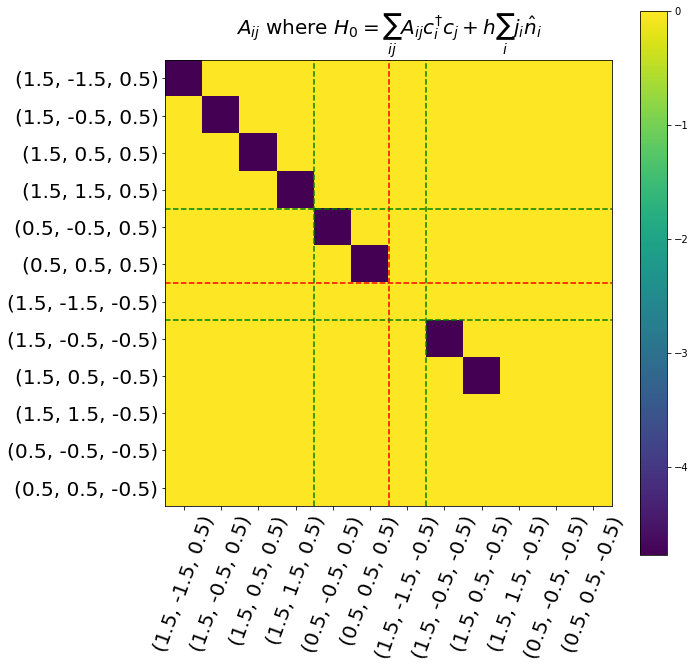

-38.16192500000005


In [34]:
omega=0
omega_b=4

InitialHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b)

kinetic_term:Dict={}
adj_matrix=np.zeros((size_a+size_b,size_a+size_b))





                
external_field=np.zeros(size_a+size_b)
rand=np.random.uniform(0,1,3)
rand_dict={1/2:rand[0],-1/2:rand[1]}

external_field=(min/(nparticles_a+nparticles_b))*min_b

        
    
        
    

    
    #external_field[i] = SPS.energies[i]


InitialHamiltonian.get_external_potential(external_field)
InitialHamiltonian.get_hamiltonian()

nlevels=8

es,psis=InitialHamiltonian.get_spectrum(n_states=nlevels)
einitial=es[0]
psi_initial=psis[:,0]
print('total_m=',SPS.compute_m_exp_value(psi=psi_initial,basis=InitialHamiltonian.basis))
#print('total J^2=',psi_initial.transpose().conjugate() @ Joperator.hamiltonian @ psi_initial)
plt.figure(figsize=(10,10))

plt.title(r'$A_{ij}$ where $H_0=\sum_{ij}A_{ij} c^{\dagger}_i c_j + h \sum_i j_i \hat{n}_i$',fontsize=20)
plt.imshow(adj_matrix+np.eye(energies.shape[0])*external_field[None,:])
plt.xticks(np.arange(diag_m.shape[0]),label,rotation=70)
plt.yticks(np.arange(diag_m.shape[0]),label)
plt.colorbar()
plt.savefig('images/fig4')
plt.tick_params(which='major',labelsize=20)
plt.axhline(y=energies.shape[0]//2-0.5,color='red',linestyle='--')
plt.axvline(x=energies.shape[0]//2-0.5,color='red',linestyle='--')

plt.axhline(y=energies.shape[0]-5.5,color='green',linestyle='--')
plt.axvline(x=energies.shape[0]-5.5,color='green',linestyle='--')


plt.axhline(y=energies.shape[0]-8.5,color='green',linestyle='--')
plt.axvline(x=energies.shape[0]-8.5,color='green',linestyle='--')

plt.show()

print(einitial)

#### Single Particle Hamiltonian

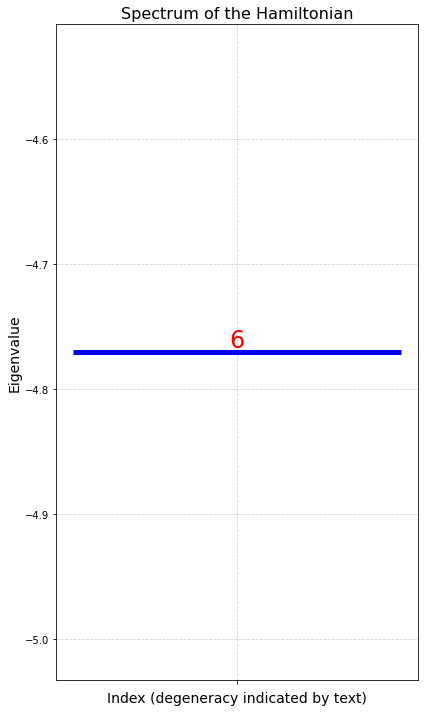

[-4.77024063 -4.77024063 -4.77024063 -4.77024063 -4.77024063 -4.77024063]
component= (1.5, -1.5, 0.5) value= 1.0 

component= (1.5, -0.5, 0.5) value= 0.0 

component= (1.5, 0.5, 0.5) value= 0.0 

component= (1.5, 1.5, 0.5) value= 0.0 

component= (0.5, -0.5, 0.5) value= 0.0 

component= (0.5, 0.5, 0.5) value= 0.0 



In [35]:
single_particle_hamiltonian=adj_matrix[:size_a,:size_a]+external_field[:size_a,None]*np.eye(size_a)


eigenvalues,states=np.linalg.eigh(single_particle_hamiltonian)

plot_spectrum(eigenvalues)
print(eigenvalues)
nstate=0
for i in range(len(label[:size_a])):
    print('component=',label[i],'value=',states[i,nstate],'\n')


### $n_i$ expectation value

In [120]:
n_expectation=np.zeros((nlevels,size_a+size_b))

for j in range(nlevels):
    for i in range(size_a+size_b):
        
        op=InitialHamiltonian.adag_a_matrix(i=i,j=i)
        n_expectation[j,i]=( (psis[:,j].conjugate().transpose() @ op @ psis[:,j]))


m_expectation=[]
j_expectation=[]
jdiag_expectation=[]
for j in range(nlevels):
    op=Moperator.hamiltonian
    op_j=Joperator.hamiltonian
    op_jdiag=Jdiagoperator.hamiltonian
    m_expectation.append( (psis[:,j].conjugate().transpose() @ op @ psis[:,j]))
    j_expectation.append((psis[:,j].conjugate().transpose() @ op_j @ psis[:,j]))
    jdiag_expectation.append((psis[:,j].conjugate().transpose() @ op_j @ psis[:,j]))

        
        
        





Plot

In [ ]:
for i in range(1,5):
    plt.plot(n_expectation[i])
    plt.scatter(np.arange(energies.shape[0]),n_expectation[i],s=50,label=f'level={i}')
    plt.xticks(np.arange(energies.shape[0]),label,rotation=70)
    
plt.legend()
plt.show()

print(es)
print(m_expectation)
print(j_expectation)
print(np.sum(n_expectation))

plt.plot(j_expectation)
plt.show()

plt.plot(m_expectation)
plt.show()

plt.plot(jdiag_expectation)
plt.show()



#### Correlation function

In [12]:
correlation_matrix=np.zeros((size_a+size_b,size_a+size_b))
for i in range(size_a):
    for j in range(size_a):
        op=InitialHamiltonian.adag_a_matrix(i=i,j=j)
        print(op,i,j,'\n')
        correlation_matrix[j,i]=( (psis[:,0].conjugate().transpose() @ op @ psis[:,0]))
        
for i in range(size_a,size_a+size_b):
    for j in range(size_a,size_a+size_b):
        op=InitialHamiltonian.adag_a_matrix(i=i,j=j)
        correlation_matrix[j,i]=( (psis[:,0].conjugate().transpose() @ op @ psis[:,0]))


  (0, 0)	1.0
  (1, 1)	1.0
  (2, 2)	1.0
  (3, 3)	1.0
  (4, 4)	1.0
  (5, 5)	1.0
  (6, 6)	1.0
  (7, 7)	1.0
  (8, 8)	1.0
  (9, 9)	1.0
  (10, 10)	1.0
  (11, 11)	1.0
  (12, 12)	1.0
  (13, 13)	1.0
  (14, 14)	1.0
  (15, 15)	1.0
  (16, 16)	1.0
  (17, 17)	1.0
  (18, 18)	1.0
  (19, 19)	1.0
  (20, 20)	1.0
  (21, 21)	1.0
  (22, 22)	1.0
  (23, 23)	1.0
  (24, 24)	1.0
  (25, 25)	1.0
  (26, 26)	1.0
  (27, 27)	1.0
  (28, 28)	1.0
  (29, 29)	1.0
  (30, 30)	1.0
  (31, 31)	1.0
  (32, 32)	1.0
  (33, 33)	1.0
  (34, 34)	1.0
  (35, 35)	1.0
  (36, 36)	1.0
  (37, 37)	1.0
  (38, 38)	1.0
  (39, 39)	1.0
  (40, 40)	1.0
  (41, 41)	1.0
  (42, 42)	1.0
  (43, 43)	1.0
  (44, 44)	1.0
  (45, 45)	1.0
  (46, 46)	1.0
  (47, 47)	1.0
  (48, 48)	1.0
  (49, 49)	1.0
  (50, 50)	1.0
  (51, 51)	1.0
  (52, 52)	1.0
  (53, 53)	1.0
  (54, 54)	1.0
  (55, 55)	1.0
  (56, 56)	1.0
  (57, 57)	1.0
  (58, 58)	1.0
  (59, 59)	1.0
  (60, 60)	1.0
  (61, 61)	1.0
  (62, 62)	1.0
  (63, 63)	1.0
  (64, 64)	1.0
  (65, 65)	1.0
  (66, 66)	1.0
  (67, 67)	1.0


Plot

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, '(1.5, -1.5, 0.5)'),
  Text(1, 0, '(1.5, -0.5, 0.5)'),
  Text(2, 0, '(1.5, 0.5, 0.5)'),
  Text(3, 0, '(1.5, 1.5, 0.5)'),
  Text(4, 0, '(0.5, -0.5, 0.5)'),
  Text(5, 0, '(0.5, 0.5, 0.5)'),
  Text(6, 0, '(1.5, -1.5, -0.5)'),
  Text(7, 0, '(1.5, -0.5, -0.5)'),
  Text(8, 0, '(1.5, 0.5, -0.5)'),
  Text(9, 0, '(1.5, 1.5, -0.5)'),
  Text(10, 0, '(0.5, -0.5, -0.5)'),
  Text(11, 0, '(0.5, 0.5, -0.5)')])

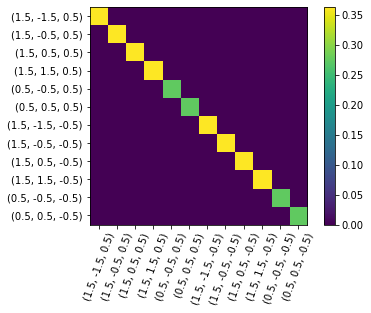

In [25]:
plt.imshow(correlation_matrix)
plt.colorbar()
plt.xticks(np.arange(energies.shape[0]),label,rotation=70)
plt.yticks(np.arange(energies.shape[0]),label)
plt.xticks()

#### Annealing

100%|██████████| 100/100 [00:00<00:00, 169.05it/s]


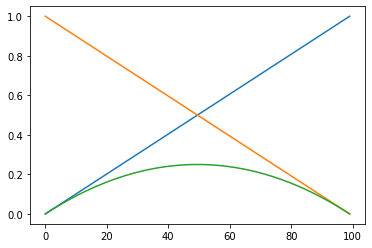

In [36]:
ngrid=100
nlevels=10
lambd=np.linspace(0,1.,ngrid)

spectrum=np.zeros((nlevels,ngrid))
psi_spectrum = np.zeros((nlevels, InitialHamiltonian.basis.shape[0]))
n_evolution=np.zeros((nlevels,ngrid, InitialHamiltonian.basis.shape[-1]))
j_values=np.zeros_like(spectrum)
m_values = np.zeros_like(spectrum)
comm=np.zeros_like(spectrum)
plt.plot(lambd)
plt.plot(1-lambd)
plt.plot(lambd*(1-lambd))

for i in trange(ngrid):

    ham=lambd[i]*TargetHamiltonian.hamiltonian+(1-lambd[i])*InitialHamiltonian.hamiltonian#+lambd[i]*(1-lambd[i])*IntermediateHamiltonian.hamiltonian   

    values,psis=eigsh(ham,k=nlevels,which='SA')
    for a in range(psis.shape[-1]):    
        j_values[a,i]=psis[:,a].conjugate().transpose() @ Joperator.hamiltonian @ psis[:,a]
        m_values[a, i] = SPS.compute_m_exp_value(psi=psis[:,a],basis=InitialHamiltonian.basis)
        comm[a,i]=(psis[:,a].conjugate().transpose() @ Moperator.hamiltonian @ InitialHamiltonian.hamiltonian- InitialHamiltonian.hamiltonian @ Moperator.hamiltonian @ psis[:,a])[0]
        # for r in range(size_a+size_b):
    
        #     op=InitialHamiltonian.adag_a_matrix(i=r,j=r)
        #     n_evolution[a,i,r]= (psis[:,a].conjugate().transpose() @ op @ psis[:,a])


    spectrum[:,i]=values
    psi_spectrum=psis

Plots

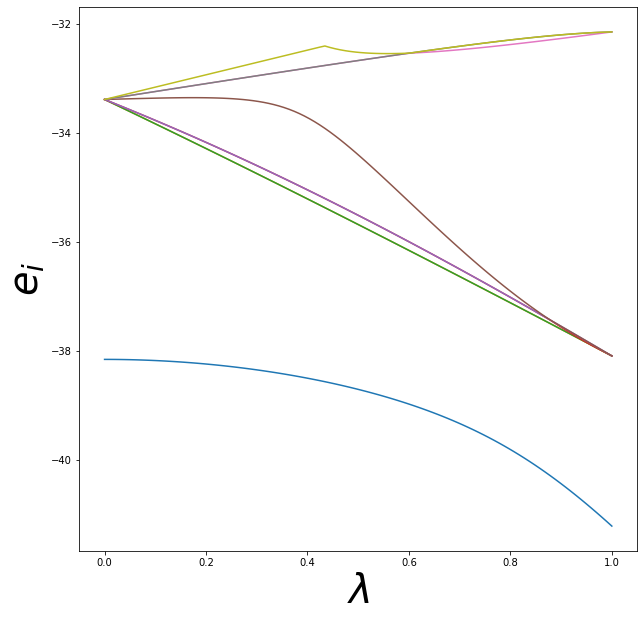

7.174035947407935
-41.22145457130283


In [37]:
plt.figure(figsize=(10,10))
for i in range(0,9):
    plt.plot(lambd,spectrum[i])
# plt.xlim([0.9,1])
#plt.axhline(y=egs, color="red", linewidth=3, linestyle="--")
plt.xlabel(r'$\lambda$',fontsize=40)
plt.ylabel(r'$e_i$',fontsize=40)


plt.show()

t_critic=np.argmax(spectrum[0])
gap=np.min(np.abs(spectrum[1,:]-spectrum[0,:]))
print((gap**2))
print(spectrum[0,-1])

M and commutators

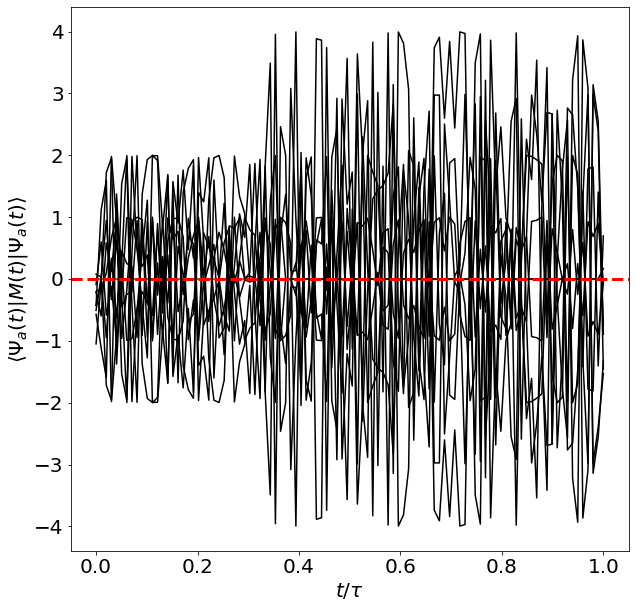

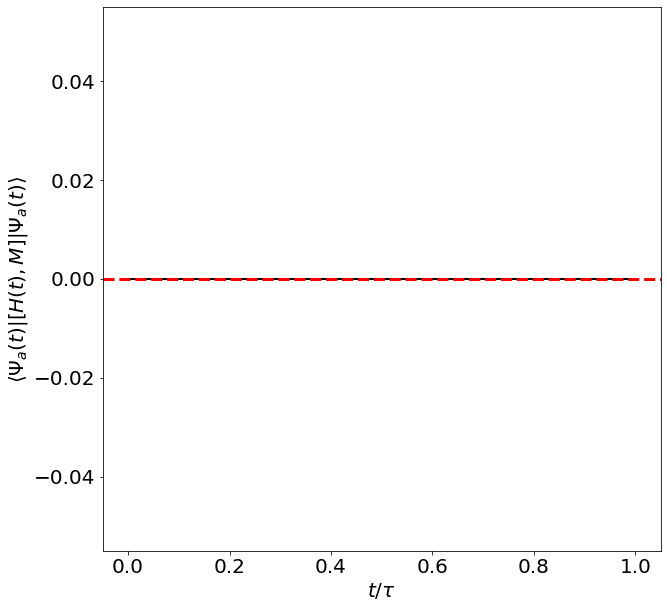

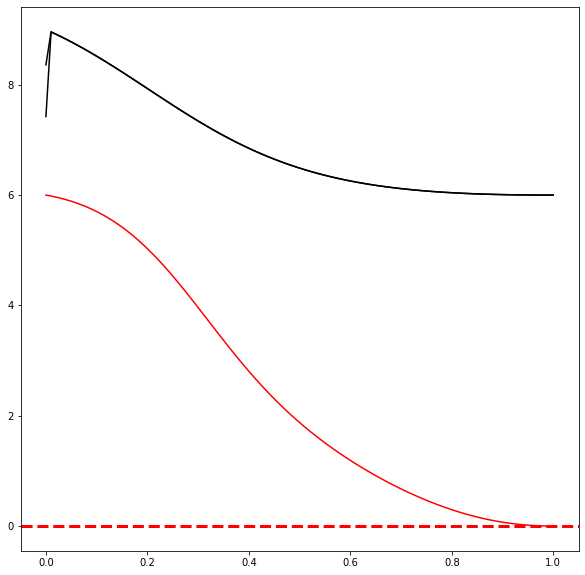

In [11]:



plt.figure(figsize=(10, 10))
plt.plot(lambd,m_values[0],color='red')
for i in range(1,10):
    plt.plot(lambd, m_values[i],color='black')
plt.axhline(y=0,color='red',linestyle='--',linewidth=3)
plt.xlabel(r'$t/\tau$',fontsize=20)
plt.ylabel(r'$\langle \Psi_a (t) | M(t) | \Psi_a (t) \rangle$',fontsize=20)
plt.tick_params(which='major',labelsize=20)

# plt.xlim([0.9,1])
plt.show()

plt.figure(figsize=(10, 10))
plt.plot(lambd,comm[0],color='red')
for i in range(1,10):
    plt.plot(lambd, comm[i],color='black')

plt.xlabel(r'$t/\tau$',fontsize=20)
plt.ylabel(r'$\langle \Psi_a (t) | [H(t),M] |\Psi_a (t) \rangle$',fontsize=20)
plt.axhline(y=0,color='red',linestyle='--',linewidth=3)
plt.tick_params(which='major',labelsize=20)

# plt.xlim([0.9,1])
plt.show()

plt.figure(figsize=(10, 10))
plt.plot(lambd,j_values[0],color='red')
for i in range(1,3):
    plt.plot(lambd, j_values[i],color='black')
plt.axhline(y=0,color='red',linestyle='--',linewidth=3)
# plt.xlim([0.9,1])
plt.show()

#### n particle number

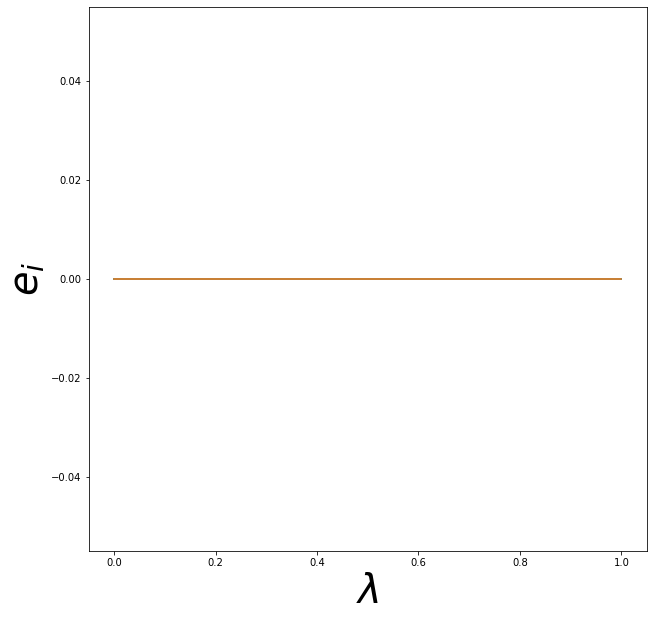

In [40]:
plt.figure(figsize=(10,10))
for r in range(energies.shape[0]):
    for i in range(1):
        plt.plot(lambd,n_evolution[i,:,r],label=f'state={r}')
        
# plt.xlim([0.9,1])
#plt.axhline(y=egs, color="red", linewidth=3, linestyle="--")
plt.xlabel(r'$\lambda$',fontsize=40)
plt.ylabel(r'$e_i$',fontsize=40)

plt.show()

##### Time Evolution

In [38]:
nstep =100
tf = 10/average_unit_energy
nlevels=10
time = np.linspace(0.0, tf, nstep)
psi = psi_initial
spectrum = np.zeros((nlevels, nstep))
probabilities=np.zeros((nlevels, nstep))
dt=time[1]-time[0]
eng_t=[]
variance_t=[]
fidelity_t=[]
lambd=1-time/tf
#gamma=1/(tf/2)
#lambd=np.exp(-gamma*time)
for i in trange(nstep):

    time_hamiltonian = (
        InitialHamiltonian.hamiltonian * ( lambd[i])
        + TargetHamiltonian.hamiltonian * (1-lambd[i])
    ) #+lambd[i]*(1-lambd[i]) * IntermediateHamiltonian.hamiltonian
    values, psis = eigsh(time_hamiltonian, k=nlevels, which="SA")
    psi=expm_multiply(-1j*dt*time_hamiltonian,psi)

    e_ave=psi.conjugate().transpose()@ time_hamiltonian @ psi
    e_square_ave = (
        psi.conjugate().transpose() @ time_hamiltonian @ time_hamiltonian @ psi
    )
    eng_t.append(e_ave)
    variance_t.append(e_square_ave-e_ave**2)
    spectrum[:, i] = values

    degenerate_fidelity=0.
    count=0
    for j in range(values.shape[0]):
        if np.isclose(values[j],values[0]):
            degenerate_fidelity += (
                psis[:, j].conjugate().transpose() @ psi[:]
            ) * np.conj(psis[:, j].conjugate().transpose() @ psi[:])
            count=count+1
        
        probabilities[j,i]=(
                psis[:, j].conjugate().transpose() @ psi[:]
            ) * np.conj(psis[:, j].conjugate().transpose() @ psi[:])

    fidelity=degenerate_fidelity        
    fidelity_t.append(fidelity)

eng_t=np.asarray(eng_t)
fidelity_t=np.asarray(fidelity_t)
variance_t=np.asarray(variance_t)
print(np.abs((egs-eng_t[-1])/egs))
print(fidelity)
print(eng_t.shape)

  0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_3982117/4055304986.py:41: ComplexWarning: Casting complex values to real discards the imaginary part
  probabilities[j,i]=(
100%|██████████| 100/100 [00:00<00:00, 421.92it/s]

0.00022240093118535456
(0.9972387252239618+0j)
(100,)


(100,)
[4.10347241e-34 5.12098598e-06 1.87202934e-05 3.55529541e-05
 4.89282324e-05 5.35407422e-05 4.76356449e-05 3.36673882e-05
 1.72752705e-05 5.06792449e-06 2.12396991e-06 1.01508255e-05
 2.69303837e-05 4.71735191e-05 6.44070174e-05 7.31968072e-05
 7.09556195e-05 5.87767756e-05 4.10855695e-05 2.42771494e-05
 1.47973821e-05 1.72483343e-05 3.30486103e-05 5.99884707e-05
 9.27594682e-05 1.24284051e-04 1.47483880e-04 1.57041924e-04
 1.50739339e-04 1.30065906e-04 9.99785819e-05 6.78754351e-05
 4.20212788e-05 2.97733706e-05 3.59895701e-05 6.19528404e-05
 1.05028022e-04 1.59107638e-04 2.15739815e-04 2.65699248e-04
 3.00687458e-04 3.14841471e-04 3.05782941e-04 7.21324952e-29
 2.02094642e-31 3.07912420e-31 1.03049768e-30 1.23465638e-31
 1.06010860e-31 1.65290057e-31 2.76682757e-32 1.23679509e-31
 3.02762741e-32 1.35834981e-31 2.13296147e-31 1.72069984e-32
 7.96682343e-32 3.94141563e-31 2.20844968e-32 3.79488283e-33
 1.41943488e-32 3.51687239e-32 1.04714470e-32 4.20671263e-32
 7.47696248e-33 2

/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/text.py:831: ComplexWarning: Casting complex values to real discards the imaginary part
  y = float(self.convert_yunits(self._y))
/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/text.py:691: ComplexWarning: Casting complex values to real discards the imaginary part
  posy = float(self.convert_yunits(self._y))


<Figure size 720x720 with 0 Axes>

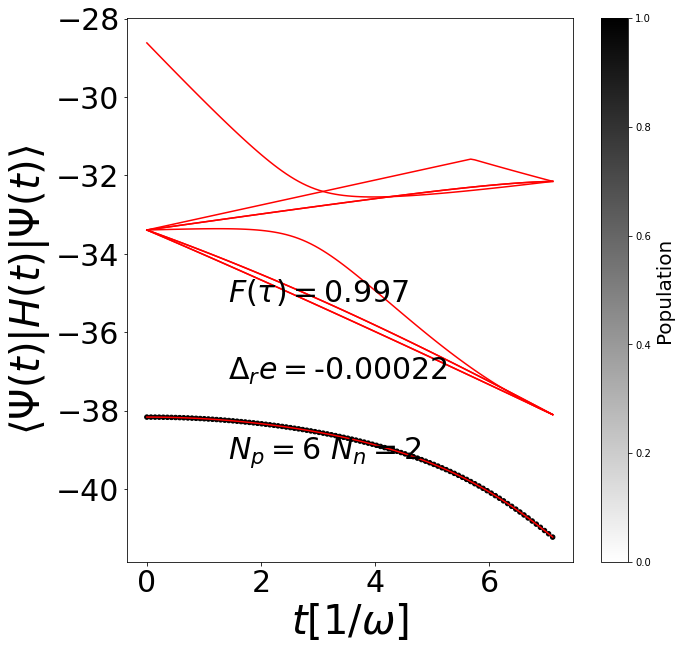

/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


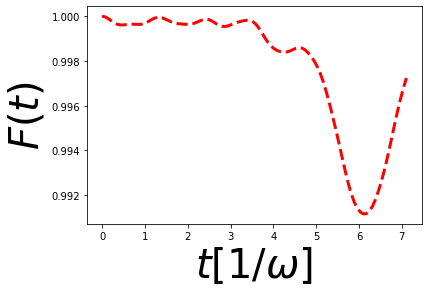

In [39]:
levels_studied=10
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list('transparency_to_black', [(0, 0, 0, 0), (0, 0, 0, 1)])
fig=plt.figure(figsize=(10,10))

print(eng_t.shape)
plt.figure(figsize=(10, 10))
print(probabilities[-1])
tot_scatters=[]

probs=probabilities[:levels_studied]

print(probabilities[1])
norm = plt.Normalize(probabilities.min(), probabilities.max())
for i in range(0,levels_studied):
    plt.plot(time, spectrum[i],color='red')

for i in range(0,levels_studied):
    plt.scatter(time, spectrum[i],c=probabilities[i],cmap=cmap,norm=norm,s=20)

#gs_scatter=plt.scatter(time,eng_t[:,0,0],c=probabilities[0,:],linestyle='--',linewidth=3,cmap='viridis',norm=norm)
#tot_scatters.append(gs_scatter)

colorbar=plt.colorbar()
colorbar.set_label('Population',fontsize=20)

# plt.xlim([0.9,1])
plt.xlabel(r'$t[1/\omega]$',fontsize=40)
plt.ylabel(r'$\langle \Psi(t)| H(t)| \Psi(t) \rangle$',fontsize=40)
plt.text(x=tf*1/5,y=eng_t[-1]+6,s=r'$F(\tau)=$'+f'{fidelity.real:.3f}',fontsize=30)
plt.text(x=tf * 1 / 5, y=eng_t[-1]+4, s=r"$\Delta_r e=$" + f"{(eng_t[-1].real-egs)/egs:.5f}", fontsize=30)

plt.text(
    x=tf * 1 / 5,
    y=eng_t[-1]+2,
    s=r"$N_p=$" + f"{nparticles_a} " + r"$N_n=$" + f"{nparticles_b}",
    fontsize=30,
)
plt.tick_params(which='major',labelsize=30)
plt.tick_params(which="minor", labelsize=30)
plt.savefig('images/fig2')
plt.show()




plt.plot(time, fidelity_t, color="red", linestyle="--", linewidth=3)
# plt.xlim([0.9,1])
plt.xlabel(r"$t [1/\omega]$", fontsize=40)
plt.ylabel(r"$F(t)$", fontsize=40)
plt.savefig('images/fig3')
plt.show()

#### Population plot

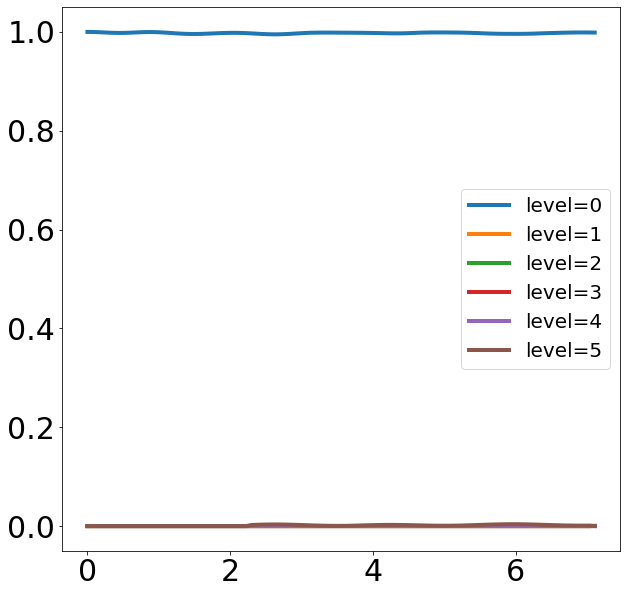

In [14]:
plt.figure(figsize=(10,10))
for i in range(6):
    
    plt.plot(time,probabilities[i],label=f'level={i}',linewidth=4)

plt.legend(fontsize=20)
plt.tick_params(which='major',labelsize=30)
plt.show()

#### $\tau$ vs Fidelity

In [40]:
tfs = np.array([1,2,4,8,16,32,64])/average_unit_energy
nsteps =10*tfs
nlevels=10

#gamma=1/(tf/2)
#lambd=np.exp(-gamma*time)
fidelities=[]
relative_err=[]
for a in range(tfs.shape[0]):
    tf=tfs[a]
    nstep=int(nsteps[a])
    time = np.linspace(0.0, tf, nstep)
    psi = psi_initial
    dt=time[1]-time[0]
    lambd=1-time/tf
    for i in trange(nstep):

        time_hamiltonian = (
            InitialHamiltonian.hamiltonian * ( lambd[i])
            + TargetHamiltonian.hamiltonian * (1-lambd[i])
        ) #+lambd[i]*(1-lambd[i]) * IntermediateHamiltonian.hamiltonian
        values, psis = eigsh(time_hamiltonian, k=nlevels, which="SA")
        psi=expm_multiply(-1j*dt*time_hamiltonian,psi)

        e_ave=psi.conjugate().transpose()@ time_hamiltonian @ psi
        e_square_ave = (
            psi.conjugate().transpose() @ time_hamiltonian @ time_hamiltonian @ psi
        )
        
    degenerate_fidelity=0.
    count=0
    for j in range(values.shape[0]):
        if np.isclose(values[j],values[0]):
            degenerate_fidelity += (
                psis[:, j].conjugate().transpose() @ psi[:]
            ) * np.conj(psis[:, j].conjugate().transpose() @ psi[:])
            count=count+1

    print('fidelity=',degenerate_fidelity,'relative energy error=',e_ave,'\n')
    fidelities.append(degenerate_fidelity)
    relative_err.append(np.abs((egs-e_ave)/egs))    


fidelities=np.asarray(fidelities)
relative_err=np.asarray(relative_err)


100%|██████████| 7/7 [00:00<00:00, 534.12it/s]


fidelity= (0.6868360714708086+0j) relative energy error= (-40.10662438118827+0j) 



100%|██████████| 14/14 [00:00<00:00, 531.83it/s]


fidelity= (0.7844702982326963+0j) relative energy error= (-40.515444531186475+1.7763568394002505e-15j) 



100%|██████████| 28/28 [00:00<00:00, 567.93it/s]


fidelity= (0.9330678954560537+0j) relative energy error= (-41.0085349326055-3.552713678800501e-15j) 



100%|██████████| 56/56 [00:00<00:00, 571.03it/s]


fidelity= (0.993322766075161+0j) relative energy error= (-41.19926819393032+8.881784197001252e-16j) 



100%|██████████| 113/113 [00:00<00:00, 557.39it/s]


fidelity= (0.9986480959385455+0j) relative energy error= (-41.2169870383831-8.881784197001252e-16j) 



100%|██████████| 227/227 [00:00<00:00, 511.44it/s]


fidelity= (0.9997357906198829+0j) relative energy error= (-41.22055178712639-7.105427357601002e-15j) 



100%|██████████| 454/454 [00:00<00:00, 509.64it/s]

fidelity= (0.9999037140538842+0j) relative energy error= (-41.2211478667383+0j) 



##### Plots

/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


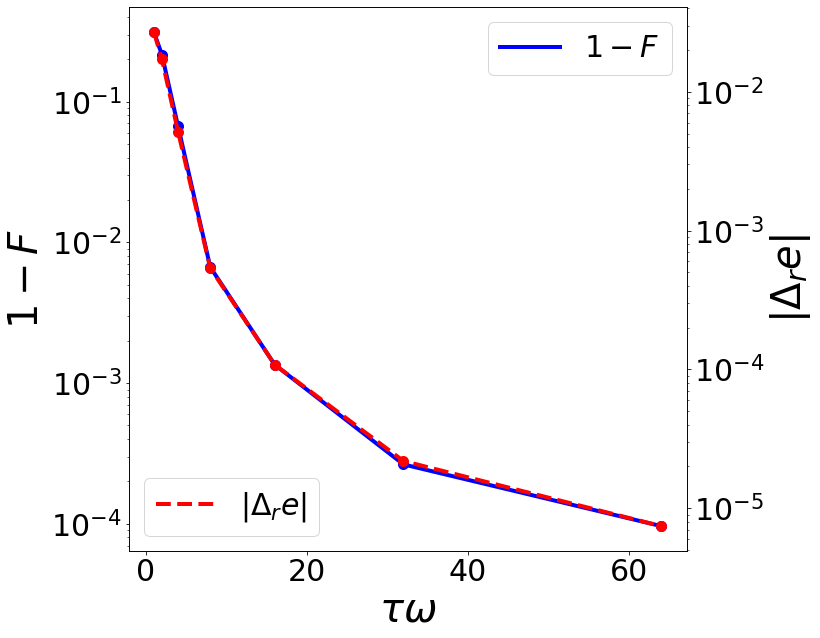

In [41]:
fig,ax=plt.subplots(figsize=(10,10))
ax.plot(tfs*average_unit_energy,1-fidelities,label=r'$1-F$',color='blue',linewidth=4,linestyle='-')
ax.scatter(tfs*average_unit_energy,1-fidelities,color='blue',s=100)
ax.semilogy()
ax.set_xlabel(r'$\tau \omega $',fontsize=40)
ax.set_ylabel(r'$1-F$',fontsize=40)
ax_twin=ax.twinx()
ax_twin.plot(tfs*average_unit_energy,relative_err,label=r'$|\Delta_r e|$',color='red',linewidth=4,linestyle='--')
ax_twin.scatter(tfs*average_unit_energy,relative_err,color='red',s=100)
ax.legend(fontsize=30)
ax_twin.semilogy()
ax_twin.legend(fontsize=30,loc='lower left')
ax_twin.set_ylabel('$|\Delta_r e|$',fontsize=40)
ax.tick_params(which='major',labelsize=30)
ax_twin.tick_params(which='major',labelsize=30)
plt.show()